### Goal: To estimate or forecast the monthly density of microbusinesses in a specific area. The issue is one of time series analysis.

Characteristics of the dataset : This competition comes with three csv files:
#### train.csv:

- row id: A row's identification number.
- cfips: A distinctive county-specific identifier for the Federal Information Processing System. The state's FIPS code is represented by the first two digits, while the county is represented by the final three digits.
- county name: the county's official name in writing.
- state name: The state's name.
- first_day_of_month : Date of the month's first day
- microbusiness_density : The number of microbusinesses in the given county per 100 adults. The target variable is this. The U.S. Census Bureau, which provides the underlying population data annually, updates its population statistics at a two-year lag, which affects the density calculations. The population estimates for 2019 are used to compute the 2021 densities, etc.
- active: The county's total number of microbusinesses. Unavailable for the test set.


#### census_starter.csv :

Examples of helpful columns from the American Community Survey (ACS) of the Census Bureau can be found at data.census.gov. The raw counts provided by the ACS were used to calculate the percentage fields. To reflect the information that was available at the time a certain microbusiness data update was published, all fields have a two-year lag.

- pctbb[year]: The proportion of county homes with any sort of broadband connection. taken from ACS table B28002, "PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD,"
- cfips: the CFIPS code.
- pctcollege[year]: The proportion of county residents over 25 who have completed a 4-year college degree. EDUCATIONAL ATTAINMENT is derived from ACS table S1501.
- pct_foreignborn[year] : The proportion of the county's population who were born outside of the United States, as measured by pct foreignborn[year]. Selected Social Characteristics in the United States, table DP02 of the American Community Survey (ACS).
- pct itworkers[year]: The proportion of the county's workforce working in information-related industries from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.
- median_hhinc[year] : The county's median household income, as of the given year. Adapted from the ACS table S1901, INCOME IN THE LAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

#### test.csv:

- row id: A row's identification number.
- cfips: A distinctive county-specific identifier for the Federal Information Processing System. The state's FIPS code is represented by the first two digits, while the county is represented by the final three digits.
- first_day_of_month : Date of the month's first day

#### sample_submission.csv:
A valid sample submission. This file will remain unchanged throughout the competition.

- row_id : An ID code for the row.
- microbusiness_density : The target variable.


In [1]:
#importing the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv
/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv


In [2]:
#reading the dataset
dfSub = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')
dfStarter = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
dfTrain = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
dfTest = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')

In [3]:
#Making a Copy of The Dataset
#I would be working with this copy through out the project while the original dataframe would be for referencing when needed .
df_Sub = dfSub.copy()
df_Starter = dfStarter.copy()
df_Train = dfTrain.copy()
df_Test =dfTest.copy()

In [4]:
#checking out number of rows and columns of each dataset
print(df_Train.shape)
print(df_Test.shape)
print(df_Sub.shape)
print(df_Starter.shape)

(122265, 7)
(25080, 3)
(25080, 2)
(3142, 26)


Along with the row id, cfips, county, and state, first day of month, microbusiness density, and active fields are included in `train data`. 

Only row id, cfips, and first day of month are present in the `test data`. 

Microbusiness density for a specific cfips and at a specific first day of month is the value to be predicted.

In [5]:
#information on the test dataset
df_Test.head(3)

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01


In [6]:
#unique dates in test dataset
df_Test.first_day_of_month.unique()

array(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01'],
      dtype=object)

Test dataset spans from, November 2022 through June 2023.

In [7]:
print('The minimum date given for the train dataset:', df_Test['first_day_of_month'].min())
print('The maximum date given for the train dataset:', df_Test['first_day_of_month'].max())

The minimum date given for the train dataset: 2022-11-01
The maximum date given for the train dataset: 2023-06-01


In [8]:
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [9]:
#information on train datset
df_Train.head(2)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198


In [10]:
df_Train.first_day_of_month.unique()

array(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
       '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
       '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
       '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
       '2022-08-01', '2022-09-01', '2022-10-01'], dtype=object)

Train dataset spans from August 2019 through October 2022.

In [11]:
print('The number of states:', df_Train['state'].nunique())
print('The minimum date given for the train dataset:',  df_Train['first_day_of_month'].min())
print('The maximum date given for the train dataset:',  df_Train['first_day_of_month'].max())

The number of states: 51
The minimum date given for the train dataset: 2019-08-01
The maximum date given for the train dataset: 2022-10-01


## What number of cfips are there?
Let's now investigate the cfips data.

In [12]:
df_Train['cfips'].nunique(), df_Test['cfips'].nunique(), df_Starter['cfips'].nunique()

(3135, 3135, 3142)

We have test and train data totaling 3135 cfips.
There are 3142 cfips overall (according to census statistics).
The train and test datasets do not contain all of the cfips for which we do have census data.

## Data Cleaning

In [13]:
#function to seperate the first day of the month from the cfips
def get_first_day_of_month(item):
    item = item.split('_')[1]
    return item

def get_cfips(item):
    item = item.split('_')[0]
    return item

In [14]:
#applying the defined function
df_Sub['first_day_of_month'] = df_Sub['row_id'].apply(get_first_day_of_month)
df_Sub['cfips'] = df_Sub['row_id'].apply(get_cfips)

In [15]:
#converting the date to datetime
df_Test['first_day_of_month'] = pd.to_datetime(df_Test['first_day_of_month'])
df_Train['first_day_of_month'] = pd.to_datetime(df_Train['first_day_of_month'])
df_Sub['first_day_of_month'] = pd.to_datetime(df_Sub['first_day_of_month'])

In [16]:
# train['first_day_of_month'] = pd.to_datetime(train['first_day_of_month'])
# train = train.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)

df_Train['year'] = df_Train['first_day_of_month'].dt.year
df_Train['month'] = df_Train['first_day_of_month'].dt.month

In [17]:
#dropping the `row_id` column because the required information has been extracted
df_Test.drop(['row_id'],axis = 1, inplace = True)
df_Train.drop(['row_id'],axis = 1, inplace = True)
df_Sub.drop(['row_id'],axis = 1, inplace = True)

In [18]:
#merging the dataset 
df_trainMerged = df_Train.merge(df_Starter, on = 'cfips', how = 'left')
df_trainMerged.head(2)

,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_bb_2017,pct_bb_2018,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,76.6,78.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,76.6,78.9,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0


In [19]:
#after merging, we can see that some columns now have null values which needs to be cleaned up
df_trainMerged.isna().sum()

cfips                     0
county                    0
state                     0
first_day_of_month        0
microbusiness_density     0
active                    0
year                      0
month                     0
pct_bb_2017               0
pct_bb_2018               0
pct_bb_2019               0
pct_bb_2020               0
pct_bb_2021               0
pct_college_2017          0
pct_college_2018          0
pct_college_2019          0
pct_college_2020          0
pct_college_2021          0
pct_foreign_born_2017     0
pct_foreign_born_2018     0
pct_foreign_born_2019     0
pct_foreign_born_2020     0
pct_foreign_born_2021     0
pct_it_workers_2017       0
pct_it_workers_2018      39
pct_it_workers_2019       0
pct_it_workers_2020       0
pct_it_workers_2021       0
median_hh_inc_2017        0
median_hh_inc_2018       39
median_hh_inc_2019        0
median_hh_inc_2020       39
median_hh_inc_2021       39
dtype: int64

In [20]:
#sample is the df_trainMerged['pct_bb_2018']column which we can also view below
df_null = df_trainMerged[df_trainMerged['pct_it_workers_2018'].isnull()]
df_null.head(2)

,cfips,county,state,first_day_of_month,microbusiness_density,active,year,month,pct_bb_2017,pct_bb_2018,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
70707,35039,Rio Arriba County,New Mexico,2019-08-01,2.472180,742,2019,8,49.1,52.1,...,0.8,NaN,0.8,0.4,0.7,33422,NaN,39952,42264.0,46994.0
70708,35039,Rio Arriba County,New Mexico,2019-09-01,2.458852,738,2019,9,49.1,52.1,...,0.8,NaN,0.8,0.4,0.7,33422,NaN,39952,42264.0,46994.0


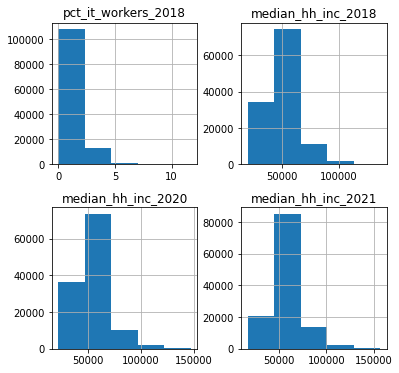

In [21]:
#showing the distribution of the columns with null values
data1 = df_trainMerged[['pct_it_workers_2018','median_hh_inc_2018', 'median_hh_inc_2020', 'median_hh_inc_2021']]
data1.hist(bins = 5, figsize=(6,6))
plt.show()

The null columns are skewed to the left they are also numerical, therfore, I would be  using the median value for replacing the missing values.


In [22]:
#filling the null values with the median
df_trainMerged['pct_it_workers_2018']= df_trainMerged['pct_it_workers_2018'].fillna(df_trainMerged['pct_it_workers_2018'].median())
df_trainMerged['median_hh_inc_2018']= df_trainMerged['median_hh_inc_2018'].fillna(df_trainMerged['median_hh_inc_2018'].median())
df_trainMerged['median_hh_inc_2020']= df_trainMerged['median_hh_inc_2020'].fillna(df_trainMerged['median_hh_inc_2020'].median())
df_trainMerged['median_hh_inc_2021']= df_trainMerged['median_hh_inc_2021'].fillna(df_trainMerged['median_hh_inc_2021'].median())

## Exploratory Data Analysis

### The top 10 counties according to their counts

In [23]:
#grouping the country based on their count in a descending order
top_county = df_trainMerged['county'].groupby(df_trainMerged['county']).size().sort_values(ascending = False)
top_county = top_county.reset_index(name='counts')
top_county.head(10)

,county,counts
0,Washington County,1170
1,Jefferson County,975
2,Franklin County,936
3,Lincoln County,897
4,Jackson County,897
5,Madison County,741
6,Montgomery County,702
7,Clay County,702
8,Marion County,663
9,Monroe County,663


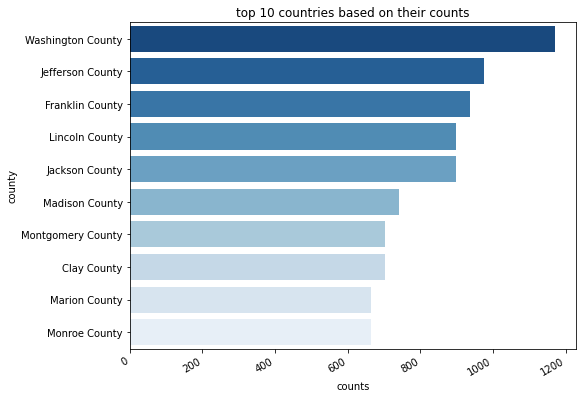

In [24]:
plt.figure(figsize = (8,6))
sns.barplot(y ='county', x = 'counts', data = top_county.head(10), linewidth = 2,  palette ='Blues_r' )
plt.xticks(rotation = 30, ha='right')
plt.title('top 10 countries based on their counts')
plt.show()

The most microbusinesses are located in Washington, Jefferson County, Franklin County, and other places.

### The top 10 county based on their microdensities

In [25]:
top_countyM = df_trainMerged.groupby('county')['microbusiness_density'].mean().sort_values(ascending=False)
top_countyM = top_countyM.reset_index()
top_countyM.head(10)

,county,microbusiness_density
0,Carson City,87.196625
1,Rio Grande County,60.942899
2,Boundary County,46.730638
3,New York County,32.892037
4,Minnehaha County,32.261295
5,Transylvania County,28.956531
6,Pitkin County,27.567022
7,Falls Church city,22.216376
8,Tulsa County,22.156203
9,Alachua County,21.545587


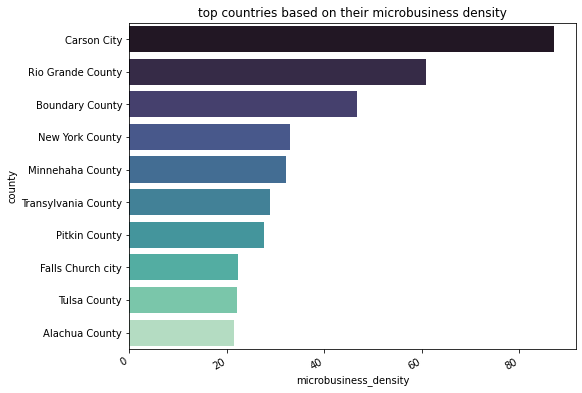

In [26]:
#average microdensitiy countries plot
plt.figure(figsize = (8,6))
sns.barplot(data = top_countyM.head(10), y = 'county', x = 'microbusiness_density', linewidth = 2,  palette ='mako')
plt.xticks(rotation = 30, ha='right')
plt.title('top countries based on their microbusiness density')
plt.show()

Carson City, Rio Grande and Boundary county have highest average microbusiness density

### The top counties with most active microbusinesses

In [27]:
#average microdensitiy countries plot
active_countyM =  df_trainMerged.groupby('county')['active'].sum().sort_values(ascending=False)
active_countyM = active_countyM.reset_index()
active_countyM.head(10)

,county,active
0,Los Angeles County,43842767
1,Orange County,23266851
2,Maricopa County,18238217
3,New York County,17943980
4,Clark County,15827161
5,San Diego County,14132392
6,Cook County,13971074
7,Miami-Dade County,13859930
8,Montgomery County,12313737
9,Harris County,11642363


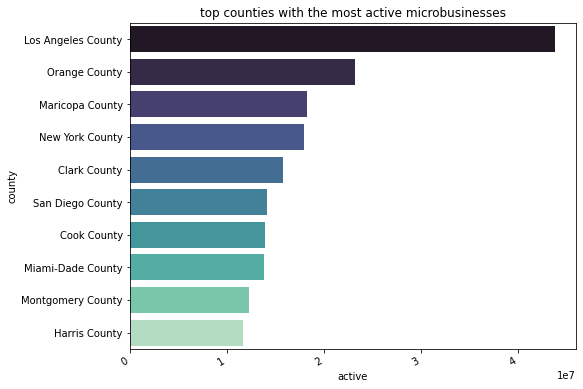

In [28]:
#average microdensitiy countries plot
plt.figure(figsize = (8,6))
sns.barplot(data = active_countyM.head(10), y = 'county', x='active', linewidth = 2,  palette ='mako')
plt.xticks(rotation = 30, ha='right')
plt.title('top counties with the most active microbusinesses')
plt.show()

Los Angeles, Orange County, Maricopa County, and other areas have the most active microbusinesses.

In [29]:
df_TrainedMerged = df_trainMerged.groupby('month')['microbusiness_density'].mean().reset_index()
df_TrainedMerged

,month,microbusiness_density
0,1,3.767546
1,2,3.779636
2,3,3.805977
3,4,3.831690
4,5,3.830886
5,6,3.820389
6,7,3.851197
7,8,3.832016
8,9,3.822233
9,10,3.857888


In [30]:
#plotting the chart
plt.figure(figsize=(5,5))
fig = px.line(df_TrainedMerged, x="month", y="microbusiness_density")
fig.update_traces(line=dict( width=3.0))

fig.update_layout(title_text ='average microbusiness density by months', yaxis_title = 'average microbusiness density',
                  xaxis_title = 'month')
#setting the chart properties
fig.update_layout(
    autosize=False,
    width=900,
    height=600,)

#showing the chart
fig.show()

<Figure size 360x360 with 0 Axes>

The month of October has the highest average(Peak Period) microbusiness density, followed by the months of July and April.

- Let's look into the number of counties in each state first. To quote Wikipedia:

Texas has the most counties with 254 while Delaware has the fewest with only 3. However, there is one exceptional state: District of Columbia, which also has its own county.

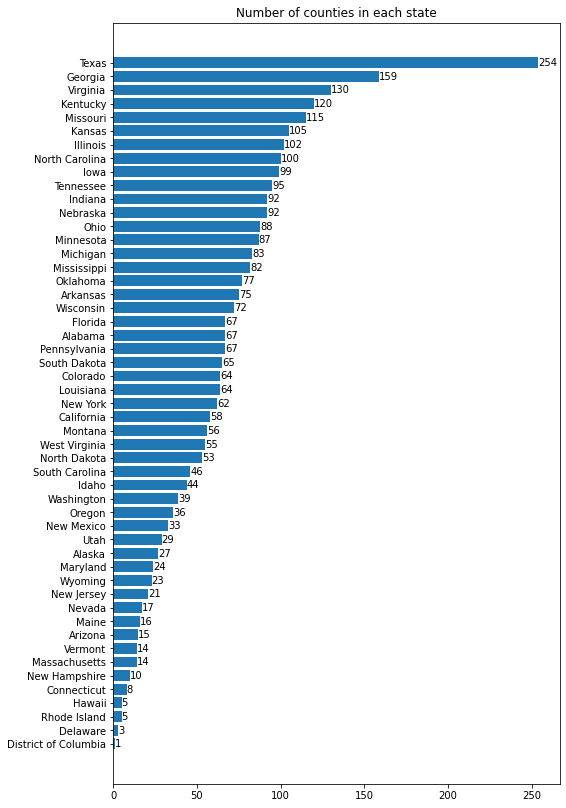

In [31]:
state_c = df_trainMerged[['state', 'cfips']].drop_duplicates(subset=['cfips']).groupby(['state']).size().sort_values()
fig, ax = plt.subplots(figsize=(8,14))
bars = ax.barh(state_c.index, state_c.values)
ax.bar_label(bars)
ax.set_title('Number of counties in each state')
plt.show()

In [32]:
df_trainMerged[['microbusiness_density', 'active']]

,microbusiness_density,active
0,3.007682,1249
1,2.884870,1198
2,3.055843,1269
3,2.993233,1243
4,2.993233,1243
...,...,...
122260,1.803249,101
122261,1.803249,101
122262,1.785395,100
122263,1.785395,100


In [33]:
df_trainMerged["microbusiness_density"].corr(df_trainMerged["active"])

0.3169811826046079

- There is a fairly strong correlation between the number of active microbusinesses and their densities

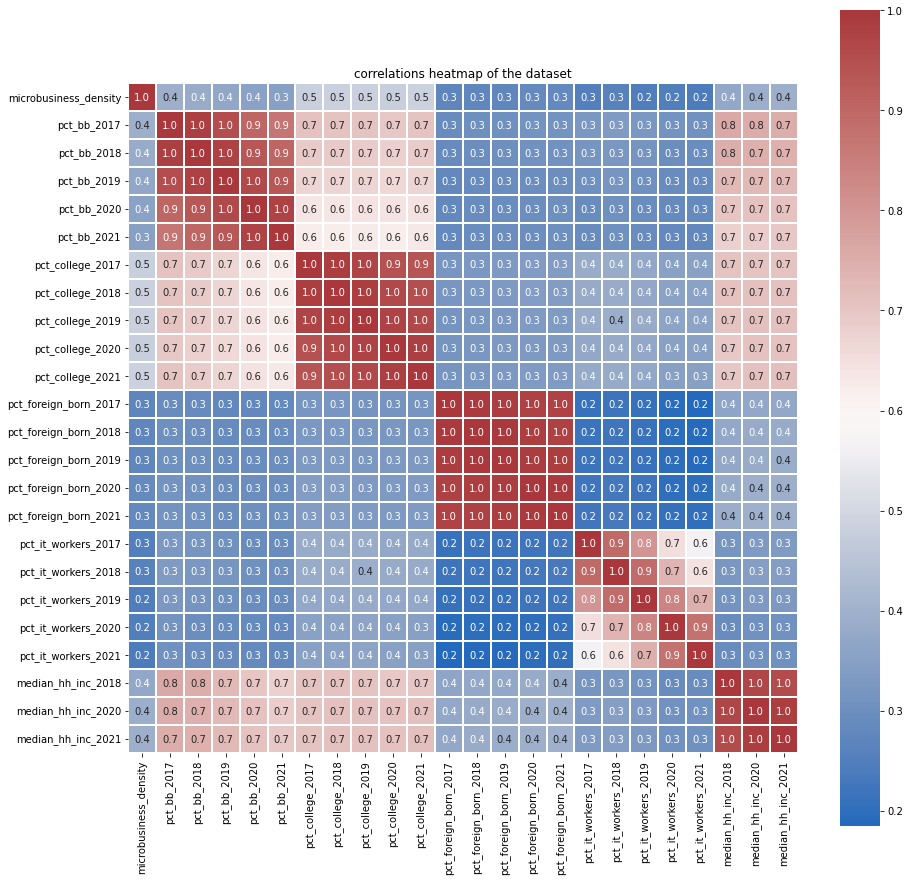

In [34]:
data_float =  df_trainMerged.select_dtypes(include="float")
plt.figure(figsize=(15,15))
sns.heatmap(data_float.corr(), annot=True,  square=True, linecolor='white',linewidths = 2, fmt= '.1f', cmap="vlag")
plt.title('correlations heatmap of the dataset', fontsize= 12)
plt.show()

It's clearly viewed that we have multi-collinearity between indepndant features themselves and hence the usage of PCA is needed for regression analysis to be performed efficiently

In [35]:
df_trainMerged.describe().T

,count,mean,std,min,25%,50%,75%,max
cfips,122265.0,30376.037640,15143.508721,1001.0,18177.000000,29173.000000,45077.000000,5.604500e+04
microbusiness_density,122265.0,3.817671,4.991087,0.0,1.639344,2.586543,4.519231,2.843400e+02
active,122265.0,6442.858218,33040.012493,0.0,145.000000,488.000000,2124.000000,1.167744e+06
year,122265.0,2020.692308,0.991089,2019.0,2020.000000,2021.000000,2022.000000,2.022000e+03
month,122265.0,6.692308,3.390452,1.0,4.000000,7.000000,10.000000,1.200000e+01
pct_bb_2017,122265.0,69.938724,9.692780,24.5,64.200000,70.800000,76.400000,9.460000e+01
pct_bb_2018,122265.0,72.707209,9.248368,25.7,67.500000,73.600000,78.800000,9.550000e+01
pct_bb_2019,122265.0,75.415981,8.832590,34.8,70.500000,76.500000,81.400000,9.600000e+01
pct_bb_2020,122265.0,78.559649,8.239703,33.3,74.100000,79.700000,84.100000,9.710000e+01
pct_bb_2021,122265.0,80.549729,7.882099,37.0,76.400000,81.700000,85.900000,9.760000e+01
